#### Fluorescence Plaques

#### Loading packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re

from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.utils import stitch_wells, remove_background, plot_virus_contours 
from PyPlaque.view import WellImageReadout, PlateReadout

np.random.seed(0)

/Users/de29/Applications/miniforge3/envs/pyplaque/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Initialising parameters and data
###### Since we would now like to get the readouts and see the usefulness other functionalities from PyPlaque for a Fluorescent Plate, we define a new ```ExperimentFluorescencePlaque``` class instance to work with them.<br> ```base_dir``` is folder above the image and mask folders for all the plates. ```params``` are set to None to choose using the default parameters but values can be updated. <br>Using ```exp.get_individual_plates()``` we get the individual plate and plate mask folders for the given pattern and ```exp.get_number_of_plates()``` gives us the number of plates found according to pattern, here just 1. The maximum number of wells per channel here for the data we have considered is 384.

In [2]:
# Loading multiple plates and plate masks as an experiment
base_dir = '../../../data_backup/samples_fluorescent_plaques/'
exp = ExperimentFluorescencePlaque(base_dir+'images', base_dir+'masks', params = None) 
# default values in class, option to update

In [3]:
# In this case, the individual plates are of 384 well plates for fluorescence plaques and
# their corresponding mask directories. Make sure to have similar directories for images 
# and masks(even if empty)
plate_dirs, plate_mask_dirs = exp.get_individual_plates(folder_pattern=r'^200601')

print(plate_dirs, plate_mask_dirs)

#We are choosing via the pattern above to ignore all other plates other than this one
print(exp.get_number_of_plates())
 

['200601-zplate-g2'] ['200601-zplate-g2']
1


#### Nuclei Channel
###### ```exp.load_wells_for_plate_nuclei()``` helps us load into memory all data for the nuclei channel, corresponding to the given index from the plates found ```plate_id``` and file pattern ```file_pattern```. Here the mask path is empty for us but they are generated at runtime using the parameters saved with the instantiation of the experiment. Please have in mind that mask generation for virus and nuclei channel follow different procedures because of ground truth beliefs about the data there, so interchanging the channels may lead to unexpected and incorrect results.<br>We also show an example where we can take only one well into consideration by using the appropriate ```file_pattern``` regex here ```'_A01_s1_w1'``` within ```exp.load_wells_for_plate_nuclei()```. Next we show reading of more wells in the nuclei channel according to other file patterns.<br>It is possible to have the images for both channels in the same directory and only tell them apart by the file pattern.

In [4]:
#Example considering 1 particular well A01 for channel w1 from the selected plate
plate_dict_w1 = exp.load_wells_for_plate_nuclei(plate_id=0, additional_subfolders='2020-06-03/2072',
                                                                        file_pattern=r'_A01_s1_w1')
print(plate_dict_w1.keys())

768it [00:00, 160611.56it/s]
  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:08<00:00,  8.31s/it]
1it [00:08,  8.31s/it]
1it [00:08,  8.31s/it]

dict_keys(['200601-zplate-g2'])


###### We then show the image name, image from the loaded data for the single well ```'_A01_s1_w1'```.

../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_A01_s1_w1.tif


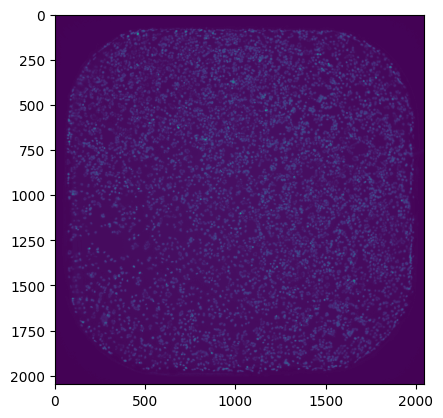

In [5]:
print(plate_dict_w1['200601-zplate-g2']['image_name'][0])
plt.imshow(plate_dict_w1['200601-zplate-g2']['img'][0])

In [6]:
# Example considering all wells for channel w1 from the selected plate
# Masks are generated based on the params given or the default at load time, masks can be saved in 
# the mask directory for future use
plate_dict_w1 = exp.load_wells_for_plate_nuclei(plate_id=0, additional_subfolders='2020-06-03/2072',
                                                file_pattern=r'_([A-C]{1})1([1-4]{1})_s1_w1') #'_w1'
print(plate_dict_w1.keys())

768it [00:00, 221511.86it/s]
  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [01:40<00:00,  8.35s/it]
12it [01:40,  8.35s/it]
12it [01:40,  8.35s/it]

dict_keys(['200601-zplate-g2'])


###### We then check the correctness of the number of images found based on our path and identification patterns.

In [7]:
print(len(plate_dict_w1[plate_dirs[0]]['img']))

12


#### Virus Channel
###### ```exp.load_wells_for_plate_virus()``` helps us load into memory all data for the virus channel, corresponding to the given index from the plates found ```plate_id``` and file pattern ```file_pattern```. File extension ```ext``` by default is '.tif' but can be changed if needed here. Here the well images are read as images and the masks path is empty and therefore masks are generated at runtime, using the parameters saved with the instantiation of the experiment. <br>We then check the correctness of the number of images found based on our path and identification patterns.

In [8]:
# Example considering all wells for channel w2 from the selected plate
# Masks are generated based on the params given or the default at load time, masks can be saved in 
# the mask directory for future use
plate_dict_w2 = exp.load_wells_for_plate_virus(plate_id=0, additional_subfolders='2020-06-03/2072',
                                                file_pattern=r'_([A-C]{1})1([1-4]{1})_s1_w2') #'_w2'
print(plate_dict_w2.keys())

768it [00:00, 352624.57it/s]
100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

dict_keys(['200601-zplate-g2'])


In [9]:
print(len(plate_dict_w2[plate_dirs[0]]['img']))

12


#### Well Stitching
###### It is possible that sometimes we wouldn't like to deal with all the 384 wells of a plate. In that case we can stitch certain wells together to generate an artificial selective view of the plate. Please note that the images passed to be stitched should be in an array in raster scan fashion from left to right, row by row and all rows and columns must be complete (i.e. number images passed should match the number of rows and columns passed). Also that the resulting ```composite_img``` should have shape ```(nrows*indiv_shape[0], ncolumns*indiv_shape[1])``` where ```indiv_shape``` is the shape of an individual well image.<br>We also show further on how we can also combine a portion of the wells to generate one corner of the well plate(in this case the top left corner of the 384 well plate) using the indices of the images or regex to identify the wells to stitch.

In [10]:
# Stitching of multiple selected wells into a composite image shown using wells in channel w1, 
# can also be done for w2

composite_img = stitch_wells(plate_dict_w1[plate_dirs[0]]['img'], nrows = 3, ncols = 4) 
#nrows = 16, ncols = 24
print(plate_dict_w1[plate_dirs[0]]['img'][0].shape)
print(composite_img.shape) 




(2048, 2048)
(6144, 8192)


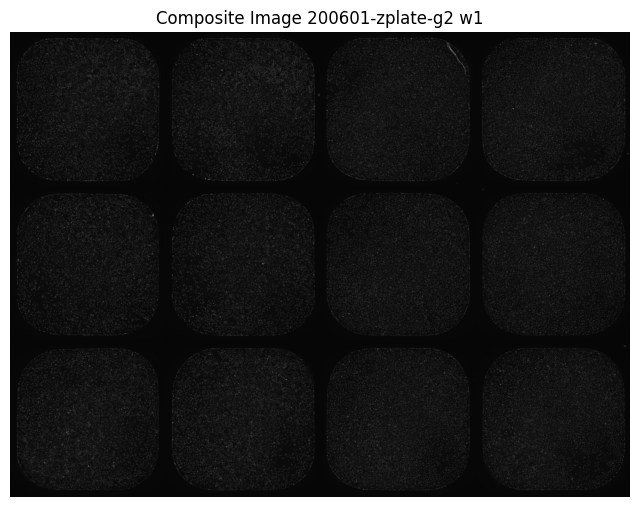

In [11]:
plt.figure(figsize=(8, 12))
plt.title("Composite Image " + plate_dirs[0] + " w1")
plt.axis('off')

plt.imshow(composite_img, cmap='gray')

# The image is more clearly visible only after converting to 8/16bit and some 
# thresholding
# plt.savefig("../../../manuscript/figs/" + plate_dirs[0] + "_w1 Stitched images.png", 
# bbox_inches = 'tight', dpi=300)

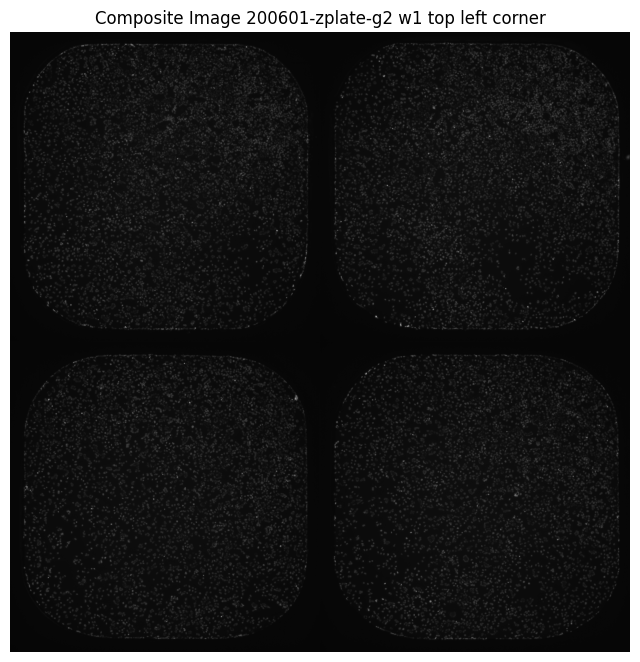

In [12]:
# change the tuple of indices to choose other wells to stitch
composite_img_corner = stitch_wells([plate_dict_w1[plate_dirs[0]]['img'][i] for i in (0, 1, 4, 5)],
                                                            nrows = 2, ncols = 2) #(0, 1, 16, 17)

# OR
# change regex to choose other wells to stitch
img_list = [img for i, img in enumerate(plate_dict_w1[plate_dirs[0]]['img'])
            if len(re.findall(r'_([A-B]{1})1([1-2]{1})_s1_w1',
            str(plate_dict_w1[plate_dirs[0]]['image_name'][i]))) > 0] #'_([A-B]{1})0([1-2]{1})_s1_w1'

composite_img_corner = stitch_wells(img_list, nrows=2, ncols=2)

plt.figure(figsize=(8, 12))
plt.title("Composite Image " + plate_dirs[0] + " w1 top left corner")
plt.axis('off')

plt.imshow(composite_img_corner, cmap='gray')

# Use one of the two methods below to save
# plt.imsave(f"../../../manuscript/figs/" + plate_dirs[0] + "_w1 stitched top left corner.png", 
# composite_img_corner, cmap='gray')
# plt.savefig("../../../manuscript/figs/" + plate_dirs[0] + "_w1 stitched top left corner.png", 
# bbox_inches = 'tight', dpi=300)

#### Mask Generation Virus Channel
###### Here we take the image from index 0 of the virus channel dictionary ```plate_dict_w2``` and show based on it the steps to mask generation that is done. First we show the original image using some constraints on the intensities that can be displayed. Then we use ```remove_background()``` to remove background and lastly plot the outline of the contours of the viral plaques identified and global maxima using red dots using ```plot_virus_contours()```. We also show the resulting binary virus mask that is formed.

In [13]:
img = plate_dict_w2[plate_dirs[0]]['img'][0]

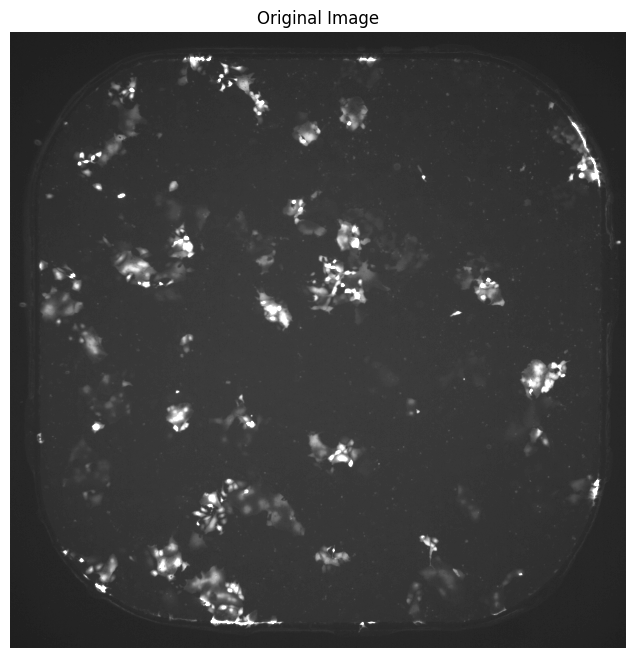

In [14]:
_, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(img, cmap='gray', vmin=500, vmax=6000, alpha=1, extent=[0, 
                                            img.shape[1], img.shape[0], 0])
ax.axis('off')

ax.set_title('Original Image')
# plt.savefig("../../../manuscript/figs/fp_original_image_w2.png", bbox_inches='tight')
plt.show()

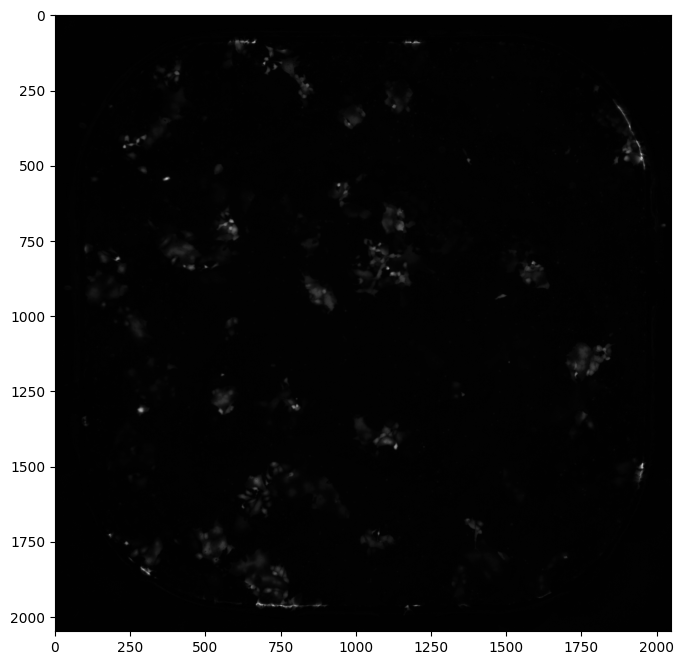

In [15]:
_, bg_removed_img = remove_background(img,
                                  radius=exp.params['virus']['correction_ball_radius'])

_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(bg_removed_img, cmap='gray')
plt.show()

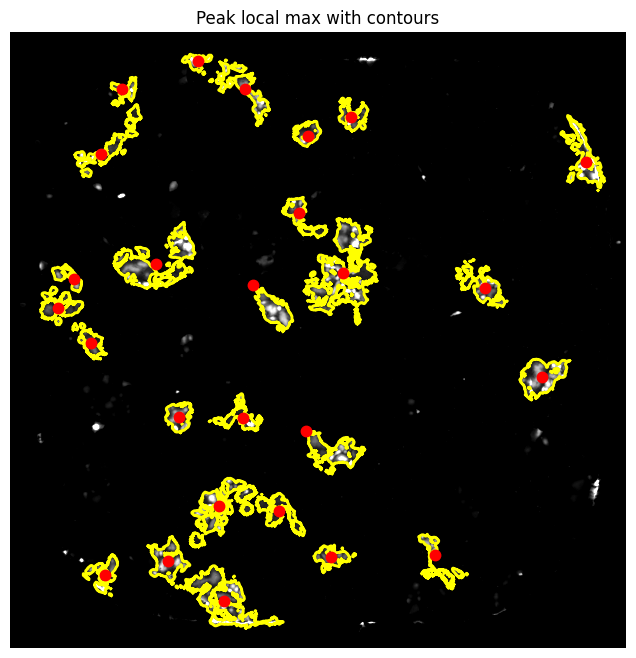

In [16]:
# Plotting the plaque contours along with the peak local maxima in each region
plot_virus_contours(img,virus_params=exp.params['virus'])

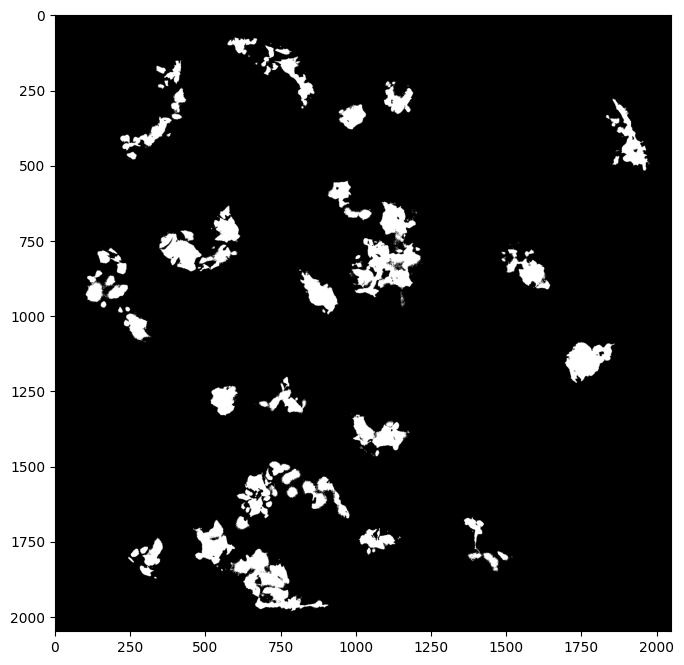

In [17]:
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(plate_dict_w2[plate_dirs[0]]['mask'][0],cmap='gray')
plt.show()

#### Mask Generation Nuclei Channel
###### Here we take the image from index 0 of the nuclei channel dictionary ```plate_dict_w1``` and show based on it the steps to mask generation that is done. First we show the original image using some constraints on the intensities that can be displayed. And then show the resulting binary nuclei mask that is formed. This is more of a one step process that virus channel and therefore does not have more nuanced output.

In [18]:
img = plate_dict_w1[plate_dirs[0]]['img'][0]

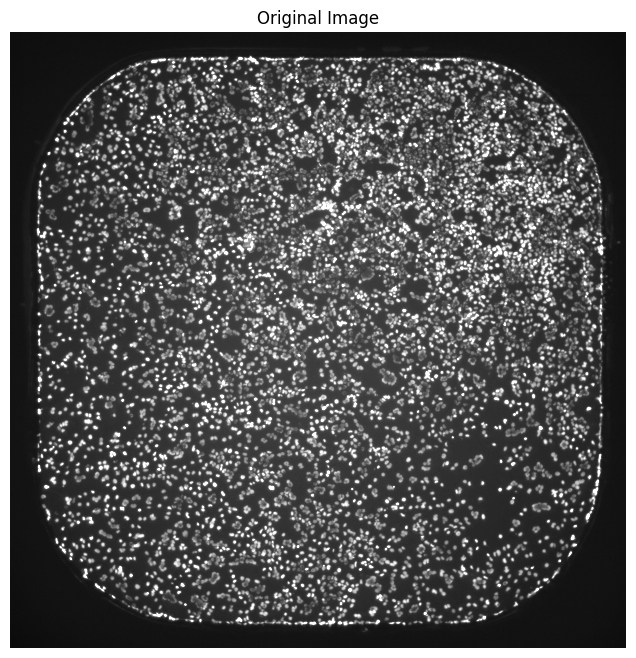

In [19]:
_, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom colormap and intensity range
ax.imshow(img, cmap='gray', vmin=500, vmax=6000, alpha=1, extent=[0, 
                                            img.shape[1], img.shape[0], 0])
ax.axis('off')

ax.set_title('Original Image')
# plt.savefig("../../../manuscript/figs/fp_original_image_w1.png", bbox_inches='tight')
plt.show()

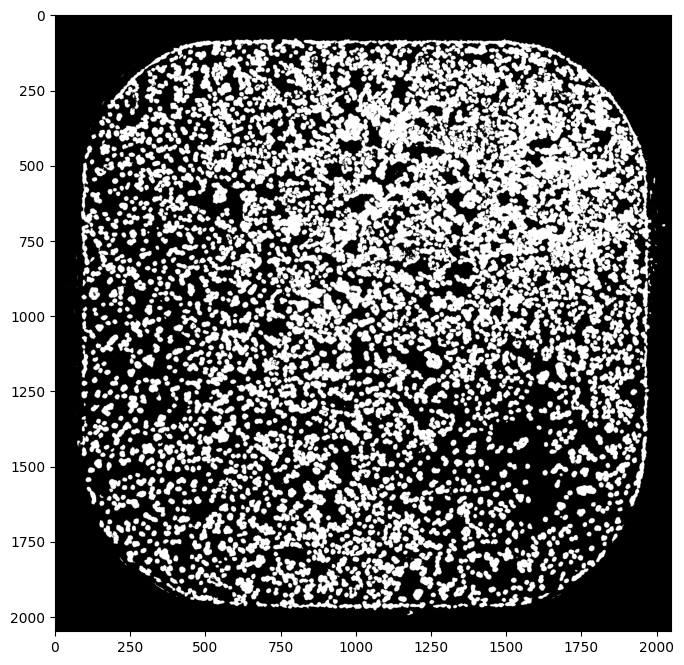

In [20]:
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(plate_dict_w1[plate_dirs[0]]['mask'][0],cmap='gray')
plt.show()

#### Plate Readout
###### We use this class ```PlateReadout``` to get the well level and object level(here a plaque is an object) readouts for our entire plate of wells. We pass the experiment class containing all our data and parameters. We can use flags to indicate whether we would like readouts at both levels. Please note that both flags for ```well_level_readouts``` and ```object_level_readouts``` cannot be set to False and will lead to errors.<br>```plate_readout.generate_readouts_dataframe()``` generates the actual dataframe of readouts. To see how the dataframe of readouts look like see ```abs_df_image``` and ```abs_df_object``` below.

In [21]:
# Generating readouts for images as in PyPlaque
plate_readout = PlateReadout(experiment = exp, plate_id = 0, well_level_readouts=True, 
                                                                    object_level_readouts=True)
abs_df_image, abs_df_object = plate_readout.generate_readouts_dataframe() 
# make sure to add row and column patterns here

100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


In [22]:
abs_df_image

,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
0,200601-zplate-g2_A11_s1_w1.tif,200601-zplate-g2_A11_s1_w2.tif,29518,8.826185e+09,1023.500000,17481,27657,7241332090,1726.468108,26,2086
1,200601-zplate-g2_A12_s1_w1.tif,200601-zplate-g2_A12_s1_w2.tif,32724,8.921454e+09,1023.500547,17578,29558,7179918904,1711.826063,29,2039
2,200601-zplate-g2_A13_s1_w1.tif,200601-zplate-g2_A13_s1_w2.tif,32691,9.022117e+09,1023.500441,18059,11473,6748545039,1608.978519,1,57
3,200601-zplate-g2_A14_s1_w1.tif,200601-zplate-g2_A14_s1_w2.tif,32727,8.890458e+09,1023.500000,17995,65535,6760565544,1611.844431,0,0
4,200601-zplate-g2_B11_s1_w1.tif,200601-zplate-g2_B11_s1_w2.tif,32579,8.237035e+09,1023.499354,14881,21967,7044377572,1679.510491,26,1794
5,200601-zplate-g2_B12_s1_w1.tif,200601-zplate-g2_B12_s1_w2.tif,32264,8.263427e+09,1023.498927,14791,30928,7069717524,1685.552007,23,1655
6,200601-zplate-g2_B13_s1_w1.tif,200601-zplate-g2_B13_s1_w2.tif,32504,8.663831e+09,1023.500270,16269,19421,6651261276,1585.784263,1,39
7,200601-zplate-g2_B14_s1_w1.tif,200601-zplate-g2_B14_s1_w2.tif,32373,8.634101e+09,1023.499971,16327,31223,6673374969,1591.056578,0,0
8,200601-zplate-g2_C11_s1_w1.tif,200601-zplate-g2_C11_s1_w2.tif,32479,8.873617e+09,1023.499705,17410,25132,7110491460,1695.273271,32,1898
9,200601-zplate-g2_C12_s1_w1.tif,200601-zplate-g2_C12_s1_w2.tif,32430,8.915507e+09,1023.500432,17862,37959,6978843370,1663.885920,23,1211


In [23]:
abs_df_object

,wellRow,wellColumn,Area,Centroid_1,Centroid_2,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,maxIntensityGFP,totalIntensityGFP,meanIntensityGFP
0,A,11,6333.975446,992.307778,813.895941,147.271312,77.480653,0.772991,10711.678571,0.086535,1.0,51.499160,39.685924,14016.892857,2.628649e+07,61.904246
1,A,12,5778.170833,1002.489548,1057.530786,127.692255,79.978626,0.686473,10081.366667,0.086975,1.0,52.560172,38.976373,12726.433333,2.407850e+07,56.826493
2,A,13,4802.562500,313.346338,1789.969199,534.812721,32.850653,0.996297,17716.000000,0.012519,2.0,148.119853,56.548529,6510.000000,1.806639e+07,142.441801
3,A,14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
4,B,11,5446.837054,1005.421259,1221.512464,131.102386,78.265477,0.702223,9755.428571,0.109898,1.0,43.046560,34.835268,11569.714286,2.175981e+07,57.709679
5,B,12,5862.562500,895.444260,1049.428091,128.958526,80.524500,0.688579,9936.541667,0.107631,1.0,44.883824,36.466728,11518.458333,2.356978e+07,57.973479
6,B,13,3312.812500,1374.993047,364.146014,174.871418,41.140870,0.952005,5978.000000,0.033200,1.0,49.759559,34.584559,6040.000000,1.258126e+07,57.986149
7,B,14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
8,C,11,6203.663462,1138.980224,992.779738,141.533034,76.823892,0.770110,10372.538462,0.084389,1.0,55.860690,41.418298,10969.692308,2.440358e+07,60.989110
9,C,12,4901.250000,940.658998,1178.284550,116.899766,74.906192,0.702879,8029.285714,0.129193,1.0,42.261099,32.508368,8965.904762,1.911349e+07,54.876464


#### Well Image Readout
###### We instantiate an instance of class ```WellImageReadout``` for a well image (index 0 for both virus and nuclei channels), passing the names, images and masks for both the nuclei and virus channels. We then extract all the readouts at the well level and corresponding to nuclei channel and virus channel. We also show the virus image and mask for the well stored by the class object.

In [24]:
# Generating readouts for each well and individual readouts can be accessed as well
well_image_readout = WellImageReadout(nuclei_image_name=str(plate_dict_w1['200601-zplate-g2']
                                       ['image_name'][0]),
                         plaque_image_name=str(plate_dict_w2['200601-zplate-g2']['image_name'][0]),
                         nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][0]),
                         plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][0]),
                         nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][0]),
                         plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][0]),
                         virus_params = exp.params['virus'])

In [25]:
print(well_image_readout.get_nuclei_image_name())
print(well_image_readout.get_row(row_pattern = r'([A-Z]{1})[0-9]{2}'))
print(well_image_readout.get_column(column_pattern = r'[A-Z]{1}([0-9]{2})'))
print(well_image_readout.get_max_nuclei_intensity())
print(well_image_readout.get_total_nuclei_intensity())
print(well_image_readout.get_mean_nuclei_intensity())
print(well_image_readout.get_nuclei_count())

../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_A11_s1_w1.tif
A
11
29518
8826185249.0
1023.5
17481


In [26]:
print(well_image_readout.get_plaque_image_name())
print(well_image_readout.get_row(row_pattern = r'([A-Z]{1})[0-9]{2}'))
print(well_image_readout.get_column(column_pattern = r'[A-Z]{1}([0-9]{2})'))
print(well_image_readout.get_max_plaque_intensity())
print(well_image_readout.get_total_plaque_intensity())
print(well_image_readout.get_mean_plaque_intensity())
print(well_image_readout.get_median_plaque_intensity())
print(well_image_readout.get_plaque_count())
print(well_image_readout.get_infected_nuclei_count())
print(well_image_readout.get_lesion_area())

../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_A11_s1_w2.tif
A
11
27657
7241332090
1726.468107700348
1655.0
26
2086
229156


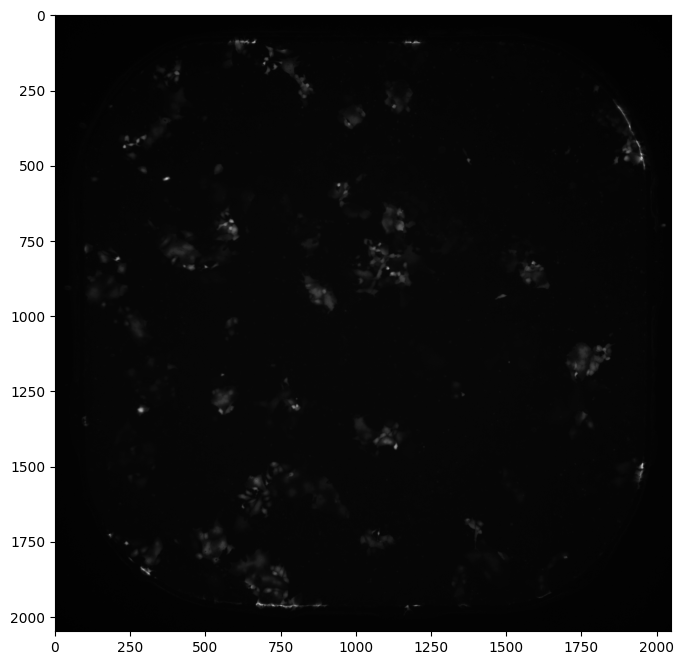

In [27]:
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(well_image_readout.plaque_image,cmap='gray')
plt.show()

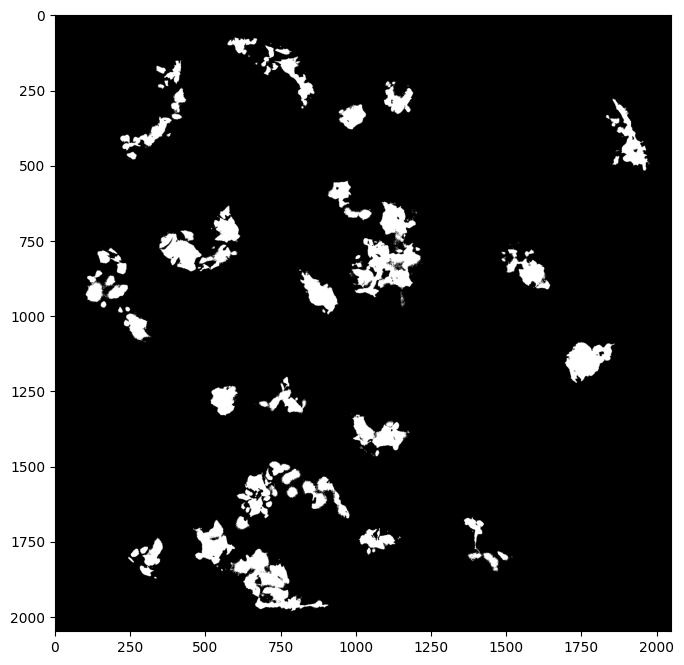

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(well_image_readout.plaque_mask,cmap='gray')
plt.show()

#### Plaque Object Readout
###### We then identify plaque objects and readouts using ```well_image_readout.get_plaque_objects()``` and ```well_image_readout.call_plaque_object_readout()``` respectively. Provided that at least 1 plaque is found, we display the readouts at the object level.

In [29]:
# Generating readouts for objects in PyPlaque
plq_objects = well_image_readout.get_plaque_objects()
len(plq_objects)

28

In [30]:
plq_object_readout = well_image_readout.call_plaque_object_readout(plq_objects[0],
                                                                    exp.params['virus'])

In [31]:
print(plq_object_readout.get_row(row_pattern = r'([A-Z]{1})[0-9]{2}'))
print(plq_object_readout.get_column(column_pattern = r'[A-Z]{1}([0-9]{2})'))
print(plq_object_readout.get_area())
print(plq_object_readout.get_centroid())
print(plq_object_readout.get_bbox())
print(plq_object_readout.get_major_minor_axis_length())
print(plq_object_readout.get_eccentricity())
print(plq_object_readout.get_convex_area())
print(plq_object_readout.roundness())
print(len(plq_object_readout.get_number_of_peaks()))
print(plq_object_readout.get_nuclei_in_plaque())
print(plq_object_readout.get_infected_nuclei_in_plaque())
print(plq_object_readout.get_max_intensity_GFP())
print(plq_object_readout.get_total_intensity_GFP())
print(plq_object_readout.get_mean_intensity_GFP())

A
11
2184.3125
(97.45176848874598, 619.5892282958199)
(74, 672, 58, 99)
(89.14519341819151, 52.20875835403844)
0.8057370563598748
3774.0
0.06410559656100132
1
15.647058823529411
14.288970588235294
24192
11998145
35.032329317269074


#### Zooming into one Plaque
###### Here we take the image from index 0 of the virus channel dictionary ```plate_dict_w2``` and for that image we get the bounding box coordinates using ```plq_object_readout.get_bbox()``` for one particular plaque. Using some padding we are able to zoom in into one particular plaque and display it. Could be useful if some plaques need special observation.

In [32]:
img = plate_dict_w2[plate_dirs[0]]['img'][0]
pad = 10
crop = img[(plq_object_readout.get_bbox()[0]-pad) : 
        (plq_object_readout.get_bbox()[0]+plq_object_readout.get_bbox()[2]+pad),
        (plq_object_readout.get_bbox()[1]-plq_object_readout.get_bbox()[3]-pad) : 
        (plq_object_readout.get_bbox()[1]+pad)]

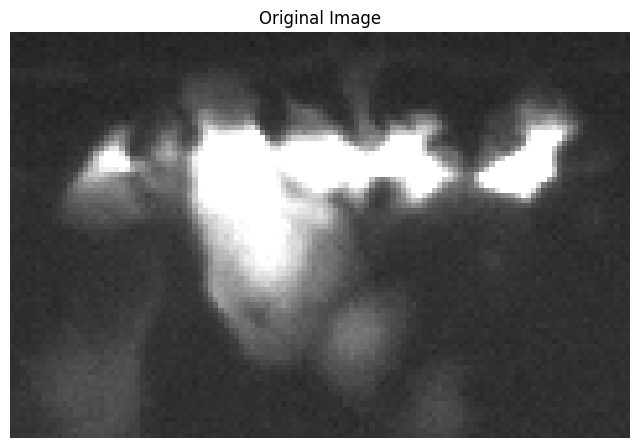

In [33]:
_, ax = plt.subplots(figsize=(8, 8))

# Display inputImage with custom' colormap and intensity range
ax.imshow(crop, cmap='gray', vmin=500, vmax=6000, alpha=1, extent=[0, 
                                            crop.shape[1], crop.shape[0], 0])
ax.axis('off')

ax.set_title('Original Image')
# plt.savefig("../../../manuscript/figs/fp_original_plaque_image_w2.png", bbox_inches='tight')
plt.show()